In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pyhf
from pyhf import hfpdf

def prep_data(source):
    spec = {
        'singlechannel': {
            'signal': {
                'data': source['bindata']['sig'],
                'mods': [
                    {
                        'name': 'mu',
                        'type': 'normfactor',
                        'data': None
                    }
                ]
            },
            'background': {
                'data': source['bindata']['bkg'],
                'mods': [
                    {
                        'name': 'bkg_norm',
                        'type': 'histosys',
                        'data': {
                            'lo_hist': source['bindata']['bkgsys_dn'],
                            'hi_hist': source['bindata']['bkgsys_up'],
                        }
                    }
                ]
            }
        }
    }
    pdf  = hfpdf(spec)
    data = source['bindata']['data'] + pdf.config.auxdata
    return data, pdf

In [3]:
source = {
  "binning": [2,-0.5,1.5],
  "bindata": {
    "data":    [120.0, 180.0],
    "bkg":     [100.0, 150.0],
    "bkgsys_up":  [102, 190],
    "bkgsys_dn":  [98, 100],
    "sig":     [30.0, 95.0]
  }
}

d,pdf = prep_data(source)
init_pars = pdf.config.suggested_init()
par_bounds = pdf.config.suggested_bounds()

print (d)
print(par_bounds)
print(pdf.config.par_order)


print '---\nas numpy\n-----'
pyhf.tensorlib = pyhf.numpy_backend(poisson_from_normal = True)
v =  pdf.logpdf(init_pars,d)
print type(v),v

print '---\nas pytorch\n-----'
pyhf.tensorlib = pyhf.pytorch_backend()
v =  pdf.logpdf(init_pars,d)
print type(v),v

[120.0, 180.0, 0]
[[0, 10], [-5, 5]]
['mu', 'bkg_norm']
---
as numpy
-----
<type 'numpy.ndarray'> [-28.41202096]
---
as pytorch
-----
<class 'torch.autograd.variable.Variable'> Variable containing:
-28.4120
[torch.FloatTensor of size 1]



In [ ]:
pyhf.tensorlib = pyhf.numpy_backend(poisson_from_normal = True)
init_pars  = pdf.config.suggested_init()
par_bounds = pdf.config.suggested_bounds()

print pyhf.tensorlib.tolist(pyhf.optimizer.unconstrained_bestfit(pyhf.loglambdav,d,pdf, init_pars, par_bounds))
print pyhf.tensorlib.tolist(pyhf.optimizer.constrained_bestfit(pyhf.loglambdav,1.0,d,pdf, init_pars, par_bounds))
print pyhf.tensorlib.tolist(pyhf.optimizer.constrained_bestfit(pyhf.loglambdav,2.0,d,pdf, init_pars, par_bounds))

In [ ]:
pyhf.tensorlib = pyhf.pytorch_backend()
pyhf.optimizer = pyhf.pytorch_optimizer(tensorlib = pyhf.tensorlib)
init_pars = pdf.config.suggested_init()
par_bounds = pdf.config.suggested_bounds()

print pyhf.tensorlib.tolist(pyhf.optimizer.unconstrained_bestfit(pyhf.loglambdav,d,pdf, init_pars, par_bounds))
print pyhf.tensorlib.tolist(pyhf.optimizer.constrained_bestfit(pyhf.loglambdav,1.0,d,pdf, init_pars, par_bounds))
print pyhf.tensorlib.tolist(pyhf.optimizer.constrained_bestfit(pyhf.loglambdav,2.0,d,pdf, init_pars, par_bounds))

In [18]:
import torch
import torch.autograd
import numpy as np

def gradient_and_hessian(func, xvars):
    gradient = None
    for x in xvars:
        if x.grad is not None:
            x.grad.data.zero_() #reset gradients
    z = func(xvars)
    z.backward(retain_graph=True)
    gradient = [
        xi.grad.data.numpy().tolist()[0] if xi.grad is not None else 0 for xi in xvars
    ]
    print 'grad',gradient
    hessian  = []
    for i in range(len(xvars)):
        for x in xvars:
            if x.grad is not None:
                x.grad.data.zero_() #reset gradients
        z = func(xvars)
        grads = torch.autograd.grad(z, xvars, create_graph=True)
        dzdxi = grads[i]

        dzdxi.backward(retain_graph=True)
        hessian.append([
            xi.grad.data.numpy().tolist()[0] if xi.grad is not None else 0 for xi in xvars
        ])
        
    print 'hess',hessian
    return gradient, hessian


def my_unconstrained_bestfit(objective, data, pdf, init_pars, par_bounds):
    def func(x):
        return objective(torch.cat(x), data, pdf)

    maxiter = 100
    for i in range(maxiter):
        xvars = [torch.autograd.Variable(torch.Tensor([v]), requires_grad=True) for v in init_pars]
        g,h = gradient_and_hessian(func, xvars)
        init_new = init_pars - 0.5*np.linalg.inv(h).dot(g)
        eps = np.max(np.abs(init_pars-init_new))
        if eps < 1e-5:
            print 'break at iter', i
            break
        init_pars = init_new
    return init_pars


def my_constrained_bestfit(objective, constrained_mu, data, pdf, init_pars, par_bounds):
    maxiter = 1000
    nuis_init = [v for i,v in enumerate(init_pars) if i != pdf.config.poi_index]
    for i in range(maxiter):

        nuis_pars = [torch.autograd.Variable(torch.Tensor([v])) for v in nuis_init]
        for nuis_p in nuis_pars: nuis_p.requires_grad = True
        poi_par   = torch.autograd.Variable(torch.Tensor([constrained_mu]))

        def func(nuis_x):
            pars = [x for x in nuis_x]
            pars.insert(pdf.config.poi_index,poi_par)
            pars = torch.cat(pars)
            return objective(pars, data, pdf)

        g,h = gradient_and_hessian(func, nuis_pars)
        nuis_new = nuis_init - 0.5*np.linalg.inv(h).dot(g)
        eps = np.max(np.abs(nuis_init-nuis_new))
        if eps < 1e-5:
            print 'break at iter', i
            break
        nuis_init = nuis_new
    result = nuis_init.tolist()
    result.insert(pdf.config.poi_index, constrained_mu)
    return result


print pdf.config.par_map.keys()

print my_unconstrained_bestfit(pyhf.loglambdav, d, pdf, [2.,2.], pdf.config.suggested_bounds())
# print my_constrained_bestfit(pyhf.loglambdav, 1.0, d, pdf, pdf.config.suggested_init(), pdf.config.suggested_bounds())
# print my_constrained_bestfit(pyhf.loglambdav, 2.0, d, pdf, [1.0,0.6], pdf.config.suggested_bounds())

['mu', 'bkg_norm']
grad [91.89826202392578, 37.689701080322266]
hess [[nan, nan], [nan, nan]]
grad [nan, nan]
hess [[nan, nan], [nan, nan]]
grad [nan, nan]
hess [[nan, nan], [nan, nan]]
grad [nan, nan]
hess [[nan, nan], [nan, nan]]
grad [nan, nan]
hess [[nan, nan], [nan, nan]]
grad [nan, nan]
hess [[nan, nan], [nan, nan]]
grad [nan, nan]
hess [[nan, nan], [nan, nan]]
grad [nan, nan]
hess [[nan, nan], [nan, nan]]
grad [nan, nan]
hess [[nan, nan], [nan, nan]]
grad [nan, nan]
hess [[nan, nan], [nan, nan]]
grad [nan, nan]
hess [[nan, nan], [nan, nan]]
grad [nan, nan]
hess [[nan, nan], [nan, nan]]
grad [nan, nan]
hess [[nan, nan], [nan, nan]]
grad [nan, nan]
hess [[nan, nan], [nan, nan]]
grad [nan, nan]
hess [[nan, nan], [nan, nan]]
grad [nan, nan]
hess [[nan, nan], [nan, nan]]
grad [nan, nan]
hess [[nan, nan], [nan, nan]]
grad [nan, nan]
hess [[nan, nan], [nan, nan]]
grad [nan, nan]
hess [[nan, nan], [nan, nan]]
grad [nan, nan]
hess [[nan, nan], [nan, nan]]
grad [nan, nan]
hess [[nan, nan]

In [9]:
def plot_results(testmus,cls_obs, cls_exp, test_size = 0.05):
    plt.plot(mutests,cls_obs, c = 'k')
    for i,c in zip(range(5),['grey','grey','grey','grey','grey']):
        plt.plot(mutests,cls_exp[i], c = c)
    plt.plot(testmus,[test_size]*len(testmus), c = 'r')
    plt.ylim(0,1)

def CLsOnePoint(muTest,d,pdf, init_pars,par_bounds):
    clsobs, cls_exp = pyhf.runOnePoint(muTest, d,pdf,init_pars,par_bounds)[-2:]
    return 1./clsobs, [1./x for x in cls_exp]

def invert_interval(testmus,cls_obs, cls_exp, test_size = 0.05):
    point05cross = {'exp':[],'obs':None}
    for cls_exp_sigma in cls_exp:
        yvals = [x for x in cls_exp_sigma]
        point05cross['exp'].append(np.interp(test_size,list(reversed(yvals)),list(reversed(testmus))))
        
    yvals = cls_obs
    point05cross['obs'] = np.interp(test_size,list(reversed(yvals)),list(reversed(testmus)))
    return point05cross

/Users/lukas/Code/histfactory/pyhf/pyhf/tensor/numpy_backend.py:41: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(tensor_in)
/Users/lukas/Code/histfactory/pyhf/venv/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1653: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
/Users/lukas/Code/histfactory/pyhf/venv/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/Users/lukas/Code/histfactory/pyhf/venv/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/Users/lukas/Code/histfactory/pyhf/venv/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1654: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x) & (scale > 0)
No handlers could be 

{'exp': [0.3046879979138327,
  0.4278663592309069,
  0.6081810860765774,
  0.8776256008370927,
  1.2094187575023085],
 'obs': 1.1150826072228623}

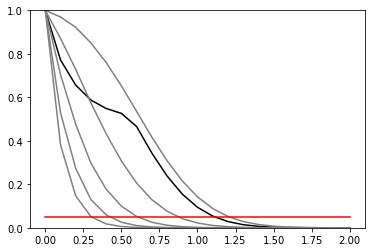

In [5]:
pyhf.tensorlib = pyhf.numpy_backend(poisson_from_normal = True)
init_pars = pdf.config.suggested_init()
par_bounds = pdf.config.suggested_bounds()

mutests = np.linspace(0,2,21)
tests = [CLsOnePoint(muTest,d,pdf,init_pars,par_bounds) for muTest in mutests]
cls_obs = [test[0]  for test in tests]
cls_exp = [[test[1][i]  for test in tests] for i in range(5)]
plot_results(mutests, cls_obs, cls_exp)
invert_interval(mutests, cls_obs, cls_exp)

{'exp': [0.3774942795427584,
  0.4780006714084854,
  0.6502737766332007,
  0.8999510053511534,
  1.2334039287726766],
 'obs': 1.1156796111522398}

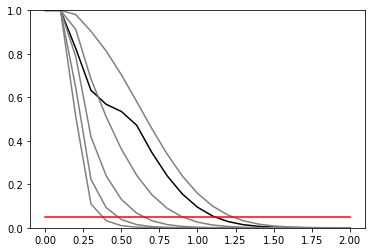

In [7]:
pyhf.tensorlib = pyhf.pytorch_backend()
pyhf.optimizer = pyhf.pytorch_optimizer(tensorlib = pyhf.tensorlib, maxdelta = 1e-1)

mutests = np.linspace(0,2,21)
tests = [CLsOnePoint(muTest,d,pdf,init_pars,par_bounds) for muTest in mutests]
cls_obs = [test[0]  for test in tests]
cls_exp = [[test[1][i]  for test in tests] for i in range(5)]
plot_results(mutests, cls_obs, cls_exp)
invert_interval(mutests, cls_obs, cls_exp)